## Environment Setting

In [1]:
# !pip install openmim
# !mim install mmengine
# !mim install mmcv
# !mim install mmdet

## Clone the file from Gihub

## Start Colorization

## Download the Model

In [2]:
#!sh scripts/download_model.sh

### Detect Object bounding box


Setting the Detectron2.

In [3]:
# We download the pre-trained checkpoints for inference and finetuning.
# !mkdir ./checkpoints
# !mim download mmdet --config mask-rcnn_x101-32x8d_fpn_ms-poly-3x_coco --dest ./checkpoints

In [4]:
from os.path import join, isfile, isdir
from os import listdir
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from argparse import ArgumentParser

import numpy as np
import cv2

from mmdet.apis import DetInferencer

# Choose to use a config
model_name = 'mask-rcnn_x101-32x8d_fpn_ms-poly-3x_coco'
# Setup a checkpoint file to load
checkpoint = './checkpoints/mask_rcnn_x101_32x8d_fpn_mstrain-poly_3x_coco_20210607_161042-8bd2c639.pth'

# Set the device to be used for evaluation
device = 'cuda:0'

# Initialize the DetInferencer
predictor = DetInferencer(model_name, checkpoint, device)

Loads checkpoint by local backend from path: ./checkpoints/mask_rcnn_x101_32x8d_fpn_mstrain-poly_3x_coco_20210607_161042-8bd2c639.pth
11/21 15:08:54 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


/home/lumi/miniconda3/envs/ai/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


Let's create a bounding box folder to save our prediction results.

In [5]:
input_dir = "example"
image_list = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
output_npz_dir = "{0}_bbox".format(input_dir)
if os.path.isdir(output_npz_dir) is False:
    print('Create path: {0}'.format(output_npz_dir))
    os.makedirs(output_npz_dir)

In [6]:

# img = 'demo.jpg'
# result = inferencer(img, out_dir='./output')

# boxes = result['predictions'][0]['bboxes']

Here we simply take L channel as our input and make sure that we can get consistent box prediction results even though the original image is color images.

In [7]:
for image_path in image_list:
    img = cv2.imread(join(input_dir, image_path))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_stack = np.stack([l_channel, l_channel, l_channel], axis=2)
    outputs = predictor(l_stack, out_dir='./output', pred_score_thr=0.7)
    save_path = join(output_npz_dir, image_path.split('.')[0])
    # pred_bbox = outputs["instances"].pred_boxes.to(torch.device('cpu')).tensor.numpy()
    pred_bbox = np.array(outputs["predictions"][0]["bboxes"])
    pred_scores = np.array(outputs["predictions"][0]["scores"])

    # Threshold by score
    pred_bbox = pred_bbox[pred_scores >= 0.7]
    pred_scores = pred_scores[pred_scores >= 0.7]

    print(pred_bbox)
    print(pred_scores)

    # pred_scores = outputs["instances"].scores.cpu().data.numpy()
    np.savez(save_path, bbox = pred_bbox, scores = pred_scores)

Output()

Output()

[[ 85.51129913 104.51289368 136.29762268 244.78335571]
 [227.37727356  93.34788513 294.48535156 275.00964355]
 [168.753479   105.7195816  236.53677368 265.00604248]
 [ 28.14361572 171.43330383 125.19055939 293.92004395]
 [131.79093933 115.64848328 181.37208557 249.11222839]
 [195.80345154  50.7403183  239.7122345   86.87059021]]
[0.99713945 0.99599659 0.99366051 0.99260557 0.96553248 0.75399762]


Output()

[[ 12.28487778 121.0872345   62.16241455 277.1630249 ]
 [160.74015808 137.25248718 209.56871033 293.11282349]
 [105.21598053 141.72798157 179.7950592  298.86618042]
 [ 37.82447052 171.54579163  85.15422058 295.38760376]
 [ 38.56986237 135.42062378 111.55303955 290.98815918]
 [144.80296326 112.63092041 175.93650818 169.59509277]
 [ 72.49982452  90.24036407 123.41804504 193.60527039]]
[0.99711704 0.99667227 0.98955357 0.98598439 0.98104697 0.94602609
 0.93917954]


Output()

[[313.13195801  60.58539581 445.64642334 370.56103516]
 [ 95.43967438 200.78627014 318.42041016 547.6998291 ]
 [203.62466431  81.05366516 372.32192993 493.94552612]
 [  3.80011153  60.81962967 200.04495239 508.04150391]
 [145.22869873  35.7495575  256.85452271 200.95794678]]
[0.99823654 0.99721861 0.99692565 0.99621743 0.99088484]


Output()

[[265.24295044 179.99487305 316.1541748  260.27166748]
 [ 99.78937531 306.5793457  334.10385132 540.45355225]
 [ 62.79021454 183.9402771  155.84707642 247.27249146]
 [302.66567993 256.01339722 346.83642578 266.62548828]
 [ 52.42831039  94.07792664  61.07398605 118.57461548]
 [119.97852325 113.31242371 135.15042114 142.49909973]
 [346.57324219 212.50115967 426.50476074 271.98812866]
 [164.23139954 204.18249512 232.57771301 256.02023315]
 [410.57873535 217.97467041 485.4697876  286.61782837]]
[0.99736589 0.99659866 0.9330864  0.90295744 0.88561678 0.86533344
 0.85427958 0.81931466 0.73389059]


Output()

[[1.38965866e+02 2.29254242e+02 3.39806488e+02 4.25876648e+02]
 [2.61546075e-01 6.22738647e+01 8.82103958e+01 2.17864273e+02]
 [0.00000000e+00 2.17811264e+02 1.42511871e+02 4.24961700e+02]
 [5.00062805e+02 1.84254044e+02 5.82196228e+02 2.56836761e+02]]
[0.89306861 0.7948103  0.78998995 0.77373487]


Output()

[[ 65.8985672  186.47766113 177.49403381 287.19732666]
 [319.32666016  78.55451965 372.07836914 267.2638855 ]]
[0.99881709 0.99860919]


/home/lumi/miniconda3/envs/ai/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:760: UserWarning: 
Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(

/home/lumi/miniconda3/envs/ai/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:831: UserWarning: 
Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(

Output()

[[489.35263062 126.16207123 596.49395752 370.36398315]
 [611.94750977 153.80680847 640.         175.1401062 ]
 [  0.          82.51512146 495.70135498 383.54650879]
 [213.35598755  43.66469955 277.30853271 106.78164673]
 [631.29840088 161.33714294 640.         180.2177124 ]
 [591.69195557 155.91815186 606.78857422 168.50483704]
 [601.27160645 149.20970154 640.         170.64904785]]
[0.99876559 0.99812073 0.98465812 0.97550344 0.84821665 0.84057635
 0.80288196]


[[200.67900085  93.25608826 379.5965271  313.01229858]
 [175.63331604 144.68075562 248.26371765 163.7559967 ]
 [148.11010742 221.72488403 285.46087646 318.53131104]
 [362.53985596 154.65927124 390.39239502 214.88809204]
 [177.45812988 162.25753784 216.89530945 232.71395874]]
[0.99969006 0.99318612 0.99236578 0.98258799 0.8919397 ]


Now we have all the images' prediction results.

In [8]:
!ls example_bbox

/bin/bash: /home/lumi/miniconda3/envs/ai/lib/libtinfo.so.6: no version information available (required by /bin/bash)
000000022969.npz  574100c6e31a1dcd096476eb2d632b3c.npz
000000023781.npz  8b01a894fb91025a1dc77611838e9d13.npz
000000046872.npz  925f179ba736e15e89bfd6d88e0bba56.npz
000000050145.npz  e9b6826aa623549ec77bbc0275002779.npz


### Colorize Images

We first set up some libraries and options

In [9]:
import sys
import time
from options.train_options import TestOptions
from models import create_model

import torch
from tqdm import tqdm_notebook

from fusion_dataset import Fusion_Testing_Dataset
from util import util
import multiprocessing
multiprocessing.set_start_method('spawn', True)

torch.backends.cudnn.benchmark = True

sys.argv = [sys.argv[0]]
opt = TestOptions().parse()

Looking for fusionmodel, available models:
dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'os', 'torch', 'OrderedDict', 'ImagePool', 'util', 'BaseModel', 'networks', 'np', 'io', 'img_as_ubyte', 'plt', 'math', 'colors', 'FusionModel'])


Then we need to create a results folder to save our predicted color images and read the dataset loader.

In [10]:
save_img_path = opt.results_img_dir
if os.path.isdir(save_img_path) is False:
    print('Create path: {0}'.format(save_img_path))
    os.makedirs(save_img_path)
opt.batch_size = 1
dataset = Fusion_Testing_Dataset(opt, -1)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size)

dataset_size = len(dataset)
print('#Testing images = %d' % dataset_size)

#Testing images = 8


/home/lumi/.local/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Load the pre-trained model.

In [15]:
print(opt.model, opt.which_direction)

fusion AtoB


In [12]:
model = create_model(opt)
model.setup_to_test('coco_finetuned_mask_256_ffs')

Looking for fusionmodel, available models:
dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'os', 'torch', 'OrderedDict', 'ImagePool', 'util', 'BaseModel', 'networks', 'np', 'io', 'img_as_ubyte', 'plt', 'math', 'colors', 'FusionModel'])
initialize network with normal
initialize network with normal
initialize network with normal
model [FusionModel] was created
load Fusion model from checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth


Start to colorize every images in `dataset_loader`.

In [17]:
count_empty = 0
for data_raw in tqdm_notebook(dataset_loader):
    data_raw['full_img'][0] = data_raw['full_img'][0].cuda()
    if data_raw['empty_box'][0] == 0:
        data_raw['cropped_img'][0] = data_raw['cropped_img'][0].cuda()
        box_info = data_raw['box_info'][0]
        box_info_2x = data_raw['box_info_2x'][0]
        box_info_4x = data_raw['box_info_4x'][0]
        box_info_8x = data_raw['box_info_8x'][0]
        cropped_data = util.get_colorization_data(data_raw['cropped_img'], opt, ab_thresh=0, p=opt.sample_p)
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)

        model.set_input(cropped_data)
        model.set_fusion_input(full_img_data, [box_info, box_info_2x, box_info_4x, box_info_8x])
        model.forward()
    else:
        count_empty += 1
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_forward_without_box(full_img_data)
    model.save_current_imgs(join(save_img_path, data_raw['file_id'][0] + '.png'))
print('{0} images without bounding boxes'.format(count_empty))

/tmp/ipykernel_124350/2738296055.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data_raw in tqdm_notebook(dataset_loader):


  0%|          | 0/8 [00:00<?, ?it/s]

tensor([[ 72, 140,  89,  45,  44, 122],
        [193,   6,  80,  19,  57, 157],
        [143,  55,  90,  27,  58, 139],
        [ 23, 150, 147,   3,  83, 106],
        [111, 102,  99,  41,  43, 116],
        [166,  53,  43, 182,  37,  31]]) tensor([[36, 70, 44, 23, 22, 61],
        [96,  3, 40, 10, 29, 78],
        [71, 28, 45, 14, 29, 69],
        [11, 75, 73,  2, 42, 53],
        [55, 51, 49, 21, 22, 58],
        [83, 27, 21, 91, 18, 16]]) tensor([[18, 35, 22, 12, 11, 30],
        [48,  2, 20,  5, 14, 39],
        [35, 14, 22,  7, 15, 35],
        [ 5, 38, 36,  1, 21, 27],
        [27, 26, 24, 11, 11, 29],
        [41, 14, 10, 46,  9,  8]]) tensor([[ 9, 18, 11,  6,  5, 15],
        [24,  1, 10,  3,  7, 19],
        [17,  7, 11,  4,  8, 17],
        [ 2, 19, 18,  1, 11, 13],
        [13, 13, 12,  6,  6, 14],
        [20,  7,  5, 23,  5,  4]])
tensor([[ 13, 189,  84,  63,  54, 109],
        [174,  29,  95,  52,  53, 109],
        [114,  62,  98,  48,  80, 110],
        [ 40, 164, 119, 

In [42]:
import matplotlib.pyplot as plt

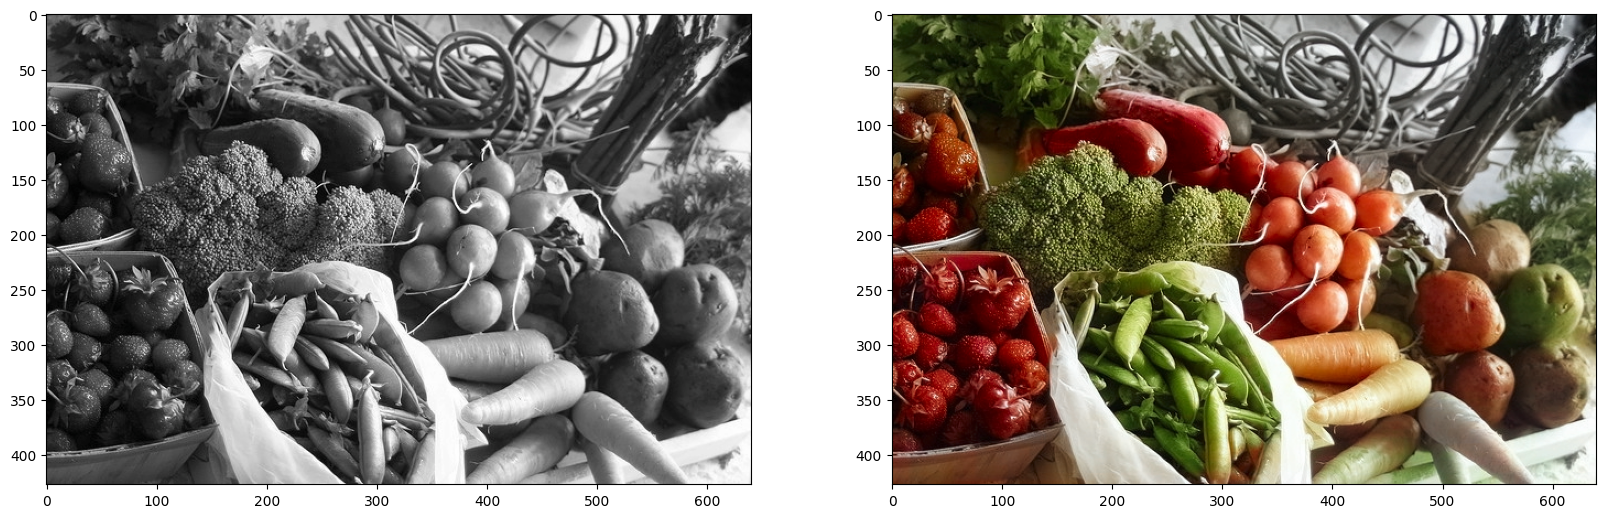

In [47]:
img_name_list = ['000000022969', '000000023781', '000000046872', '000000050145']
show_index = 1

img = cv2.imread('example/'+img_name_list[show_index]+'.jpg')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, _, _ = cv2.split(lab_image)

img = cv2.imread('results/'+img_name_list[show_index]+'.png')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
_, a_pred, b_pred = cv2.split(lab_image)
a_pred = cv2.resize(a_pred, (l_channel.shape[1], l_channel.shape[0]))
b_pred = cv2.resize(b_pred, (l_channel.shape[1], l_channel.shape[0]))
gray_color = np.ones_like(a_pred) * 128

gray_image = cv2.cvtColor(np.stack([l_channel, gray_color, gray_color], 2), cv2.COLOR_LAB2RGB)
color_image = cv2.cvtColor(np.stack([l_channel, a_pred, b_pred], 2), cv2.COLOR_LAB2RGB)

# save_img_path = 'results_origin/'
# if os.path.isdir(save_img_path) is False:
#     print('Create path: {0}'.format(save_img_path))
#     os.makedirs(save_img_path)

# cv2.imwrite('results_origin/'+img_name_list[show_index]+'.png', color_image)

# Show the gray and color together
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(gray_image)
plt.subplot(1, 2, 2)
plt.imshow(color_image)
plt.show()
